## 1. 프로젝트 개요 & 분석 목표

### 1-1. 프로젝트 개요
본 프로젝트는 포르투갈 은행의 마케팅 캠페인 데이터를 활용하여,
고객이 **정기예금(Deposit)에 가입할 가능성(y=yes)** 을 예측하는 분류 모델을 구축하는 것을 목표로 한다.

데이터는 2008년~2010년 기간의 캠페인 결과 및 고객 특성, 이전 캠페인 이력, 거시경제 지표 등을 포함한다.
마케팅 담당자의 관점에서 “누구에게/언제/어떻게 연락해야 가입 효율이 높아지는가?”를 데이터 기반으로 해석한다.

### 1-2. 분석 목표
- (1) 고객의 정기예금 가입 여부(y)를 예측하는 분류 모델을 개발한다.
- (2) 결정트리와 앙상블 모델을 비교하여 가장 성능이 좋은 모델을 선택한다.
- (3) 모델 해석(중요 변수)을 기반으로 캠페인 효율을 높이는 실행 전략을 제시한다.

### 1-3. 핵심 분석 질문
1) 특정 직업군(job)에서 정기예금 가입률이 높은가?  
2) 교육 수준(education)에 따라 가입률이 달라지는가?  
3) 과거 캠페인 결과(poutcome)가 현재 가입에 영향을 주는가?  
4) 월(month)별 가입률 차이는 존재하는가?  
5) 나이(age)와 가입 여부의 관계는 무엇인가?  
6) 가입 예측에 가장 중요한 변수는 무엇인가?

### 1-4. 산출물
- 분석 과정 및 결과가 포함된 ipynb
- 가설/분석 흐름/인사이트/전략이 포함된 보고서(PDF)

### 1-5. 모델링/평가 기준(이번 노트북 기준)
- 사용 모델: DecisionTree / RandomForest / GradientBoosting
- 평가 지표: ROC-AUC, F1-score
- 데이터 분할: Random Train/Test Split (stratify로 클래스 비율 유지)

※ 주의: `duration`(통화 지속시간)은 통화 후에만 알 수 있어 사전 타깃팅 목적에서는 누수 가능성이 크므로 본 분석에서는 제외한다.

# 미션4: Bank Marketing 분류 프로젝트

## 1단계) 데이터 로드 & 기본 점검
- 데이터 불러오기 (구분자 확인)
- 데이터 크기/컬럼 확인
- 타깃(y) 분포 확인
- 범주형의 "unknown" 값 현황 확인

In [1]:
# 데이터 분석을 위한 라이브러리 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # 경고 무시

sns.set_theme(style="whitegrid")

# plt.rc('font', family='Malgun Gothic')
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 깨질 때 윈도우용
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 깨짐 방지

In [2]:
# # csv 파일 불러오기
BANK_FILE_PATH = './content/bank-additional-full.csv'
df = pd.read_csv(BANK_FILE_PATH, sep=';')

# 로드가 잘 되었는지 상위 5행만 확인
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# 데이터 크기 확인
n_rows, n_cols = df.shape

print(f"행(row) 수: {n_rows:,}")
print(f"열(column) 수: {n_cols}")

행(row) 수: 41,188
열(column) 수: 21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
# 결측치 개수 (NaN 기준)
na_cnt = df.isna().sum().sort_values(ascending=False)
print("NaN 결측치(상위 10개):")
display(na_cnt.head(10))

# 중복 행 개수
dup_cnt = df.duplicated().sum()
print("중복 행 개수:", dup_cnt)

NaN 결측치(상위 10개):


age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
dtype: int64

중복 행 개수: 12


In [7]:
# 타깃(y) 분포 확인
target_counts = df["y"].value_counts()
target_ratio = df["y"].value_counts(normalize=True)

display(pd.DataFrame({"count": target_counts, "ratio": target_ratio}))

,count,ratio
y,,
no,36548,0.887346
yes,4640,0.112654


In [8]:
# 범주형의 "unknown" 현황 확인
cat_cols = df.select_dtypes(include="object").columns.tolist()

unknown_counts = (df[cat_cols] == "unknown").sum().sort_values(ascending=False)
unknown_ratio = ((df[cat_cols] == "unknown").mean() * 100).sort_values(ascending=False)

unknown_summary = pd.DataFrame({
    "unknown_count": unknown_counts,
    "unknown_ratio(%)": unknown_ratio.round(2)
})

unknown_summary

,unknown_count,unknown_ratio(%)
default,8597,20.87
education,1731,4.20
housing,990,2.40
loan,990,2.40
job,330,0.80
marital,80,0.19
contact,0,0.00
month,0,0.00
day_of_week,0,0.00
poutcome,0,0.00


## 2단계) EDA: 가입률(정기예금 y=yes) 비교

목표:
- 어떤 고객/상황에서 가입률이 높아지는지 빠르게 파악한다.
- 아래 항목별로 가입률(%)과 표본 수(n)를 함께 본다.

분석 항목(5~6개):
1. job별 가입률
2. education별 가입률
3. age(구간)별 가입률
4. poutcome(이전 캠페인 결과)별 가입률
5. month별 가입률
6. campaign(연락 횟수 구간)별 가입률

In [9]:
# 타깃 이진화
df["y_bin"] = (df["y"] == "yes").astype(int)

,job,rate,n,rate(%)
8,student,0.314286,875,31.43
5,retired,0.252326,1720,25.23
10,unemployed,0.142012,1014,14.20
0,admin.,0.129726,10422,12.97
4,management,0.112175,2924,11.22
11,unknown,0.112121,330,11.21
9,technician,0.108260,6743,10.83
6,self-employed,0.104856,1421,10.49
3,housemaid,0.100000,1060,10.00
2,entrepreneur,0.085165,1456,8.52


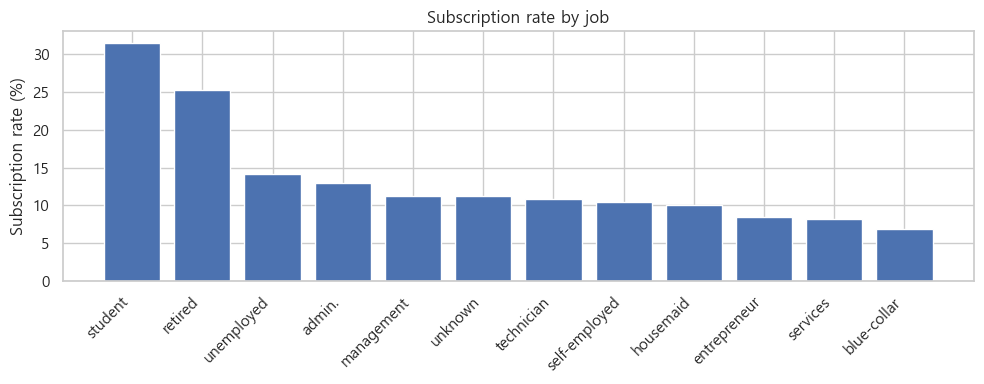

In [10]:
# 2-1) job별 가입률 (표 + 그래프)
job_tbl = (
    df.groupby("job")["y_bin"]
      .agg(rate="mean", n="count")
      .reset_index()
)
job_tbl["rate(%)"] = (job_tbl["rate"] * 100).round(2)
job_tbl = job_tbl.sort_values("rate(%)", ascending=False)

display(job_tbl)

plt.figure(figsize=(10,4))
plt.bar(job_tbl["job"].astype(str), job_tbl["rate(%)"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Subscription rate (%)")
plt.title("Subscription rate by job")
plt.tight_layout()
plt.show()

,education,rate,n,rate(%)
4,illiterate,0.222222,18,22.22
7,unknown,0.145003,1731,14.50
6,university.degree,0.137245,12168,13.72
5,professional.course,0.113485,5243,11.35
3,high.school,0.108355,9515,10.84
0,basic.4y,0.102490,4176,10.25
1,basic.6y,0.082024,2292,8.20
2,basic.9y,0.078246,6045,7.82


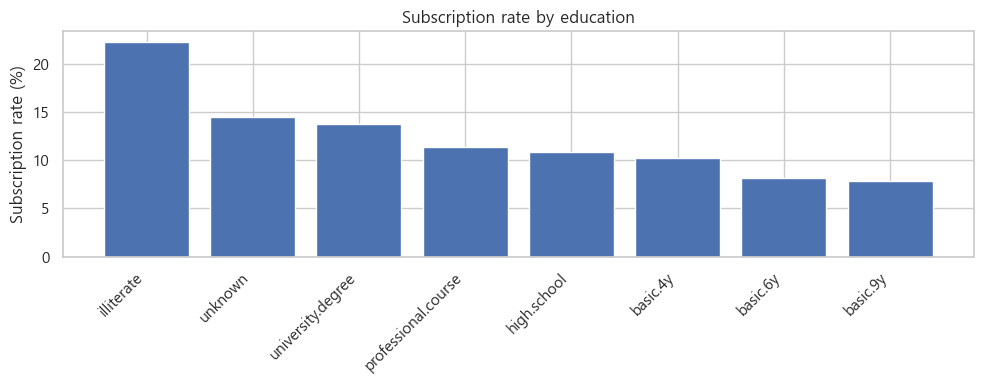

In [11]:
# 2-2) education별 가입률
edu_tbl = (
    df.groupby("education")["y_bin"]
      .agg(rate="mean", n="count")
      .reset_index()
)
edu_tbl["rate(%)"] = (edu_tbl["rate"] * 100).round(2)
edu_tbl = edu_tbl.sort_values("rate(%)", ascending=False)

display(edu_tbl)

plt.figure(figsize=(10,4))
plt.bar(edu_tbl["education"].astype(str), edu_tbl["rate(%)"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Subscription rate (%)")
plt.title("Subscription rate by education")
plt.tight_layout()
plt.show()

,age_group,rate,n,rate(%)
0,<=29,0.162639,5669,16.26
1,30-39,0.101252,16938,10.13
2,40-49,0.079232,10526,7.92
3,50-59,0.101574,6862,10.16
4,60-69,0.346685,724,34.67
5,70+,0.471215,469,47.12


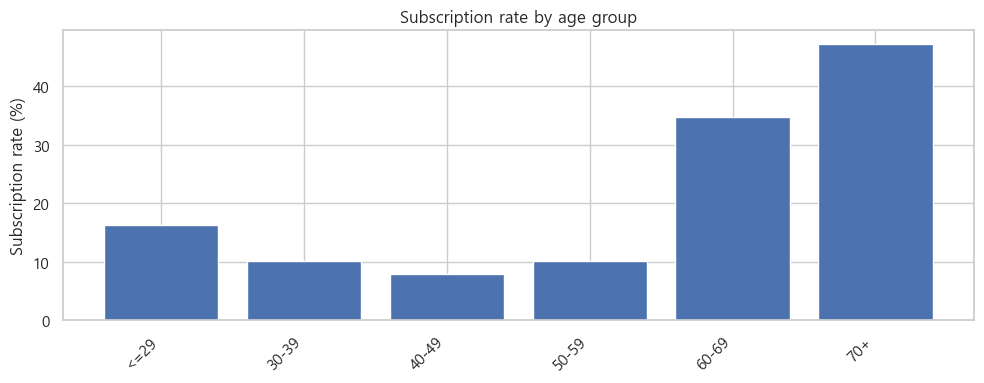

In [12]:
# 2-3) age 구간별 가입률
age_bins = [0, 29, 39, 49, 59, 69, 120]
age_labels = ["<=29", "30-39", "40-49", "50-59", "60-69", "70+"]

df["age_group"] = pd.cut(df["age"], bins=age_bins, labels=age_labels, include_lowest=True)

age_tbl = (
    df.groupby("age_group")["y_bin"]
      .agg(rate="mean", n="count")
      .reset_index()
)
age_tbl["rate(%)"] = (age_tbl["rate"] * 100).round(2)

display(age_tbl)

plt.figure(figsize=(10,4))
plt.bar(age_tbl["age_group"].astype(str), age_tbl["rate(%)"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Subscription rate (%)")
plt.title("Subscription rate by age group")
plt.tight_layout()
plt.show()

,poutcome,rate,n,rate(%)
2,success,0.651129,1373,65.11
0,failure,0.142286,4252,14.23
1,nonexistent,0.088322,35563,8.83


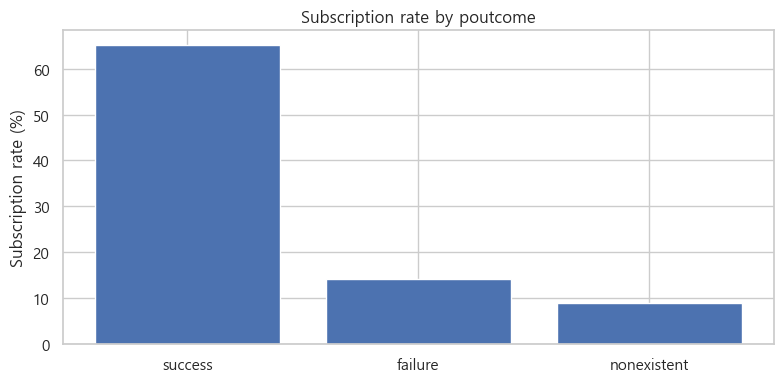

In [13]:
# poutcome별 가입률
pout_tbl = (
    df.groupby("poutcome")["y_bin"]
      .agg(rate="mean", n="count")
      .reset_index()
)
pout_tbl["rate(%)"] = (pout_tbl["rate"] * 100).round(2)
pout_tbl = pout_tbl.sort_values("rate(%)", ascending=False)

display(pout_tbl)

plt.figure(figsize=(8,4))
plt.bar(pout_tbl["poutcome"].astype(str), pout_tbl["rate(%)"])
plt.xticks(rotation=0)
plt.ylabel("Subscription rate (%)")
plt.title("Subscription rate by poutcome")
plt.tight_layout()
plt.show()


,month,rate,n,rate(%)
5,mar,0.505495,546,50.55
0,apr,0.204787,2632,20.48
6,may,0.064347,13769,6.43
4,jun,0.105115,5318,10.51
3,jul,0.090466,7174,9.05
1,aug,0.106021,6178,10.60
9,sep,0.449123,570,44.91
8,oct,0.438719,718,43.87
7,nov,0.101439,4101,10.14
2,dec,0.489011,182,48.90


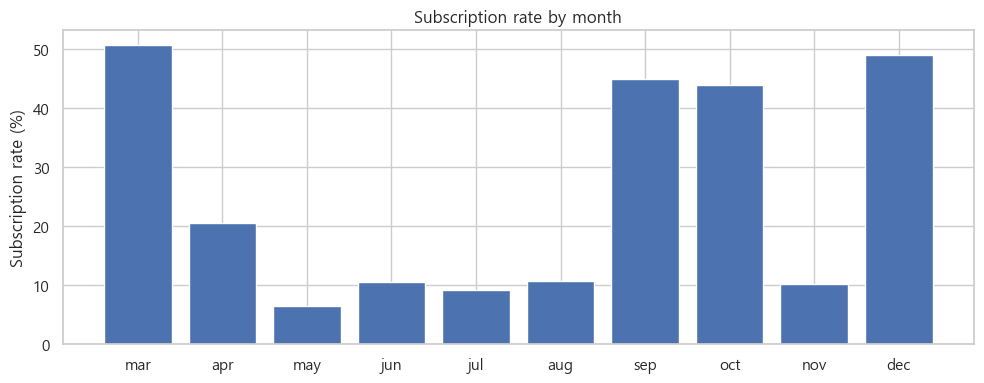

In [14]:
# 2-5) month별 가입률 (월 순서 정렬)
month_order = ["mar","apr","may","jun","jul","aug","sep","oct","nov","dec","jan","feb"]

month_tbl = (
    df.groupby("month")["y_bin"]
      .agg(rate="mean", n="count")
      .reset_index()
)
month_tbl["rate(%)"] = (month_tbl["rate"] * 100).round(2)

# 월 순서 적용(없는 월이 있으면 자동으로 NaN 처리될 수 있음)
month_tbl["month"] = pd.Categorical(month_tbl["month"], categories=month_order, ordered=True)
month_tbl = month_tbl.sort_values("month")

display(month_tbl)

plt.figure(figsize=(10,4))
plt.bar(month_tbl["month"].astype(str), month_tbl["rate(%)"])
plt.xticks(rotation=0)
plt.ylabel("Subscription rate (%)")
plt.title("Subscription rate by month")
plt.tight_layout()
plt.show()

,campaign_group,rate,n,rate(%)
0,1,0.130371,17642,13.04
1,2,0.114570,10570,11.46
2,3,0.107471,5341,10.75
3,4-5,0.086824,4250,8.68
4,6-10,0.063196,2516,6.32
5,11+,0.031070,869,3.11


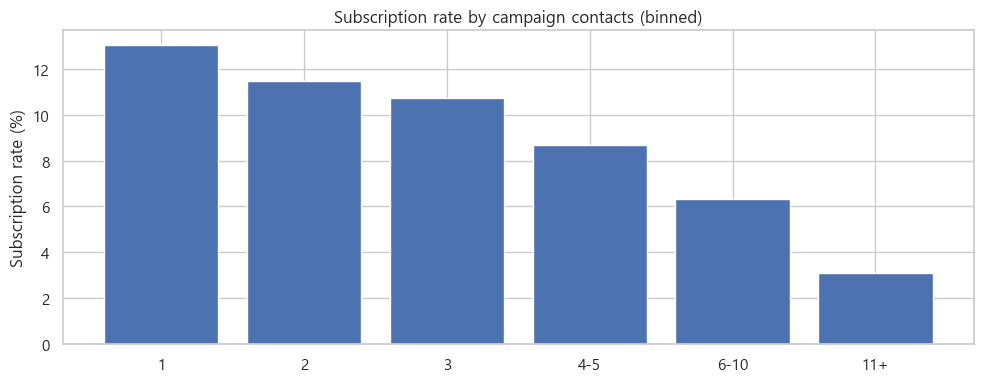

In [15]:
# 2-6) campaign 구간별 가입률
camp_bins = [0, 1, 2, 3, 5, 10, 999]
camp_labels = ["1", "2", "3", "4-5", "6-10", "11+"]

df["campaign_group"] = pd.cut(df["campaign"], bins=camp_bins, labels=camp_labels, include_lowest=True)

camp_tbl = (
    df.groupby("campaign_group")["y_bin"]
      .agg(rate="mean", n="count")
      .reset_index()
)
camp_tbl["rate(%)"] = (camp_tbl["rate"] * 100).round(2)

display(camp_tbl)

plt.figure(figsize=(10,4))
plt.bar(camp_tbl["campaign_group"].astype(str), camp_tbl["rate(%)"])
plt.xticks(rotation=0)
plt.ylabel("Subscription rate (%)")
plt.title("Subscription rate by campaign contacts (binned)")
plt.tight_layout()
plt.show()

## 3단계) 전처리 + 랜덤(train/test) 분할

- `duration` 제외 (누수 가능성)
- 타깃: `y_bin` (yes=1, no=0)
- 범주형(object + category): One-Hot Encoding
- EDA 파생 컬럼(age_group, campaign_group 등)이 있으면 제거
- stratify로 y 비율 유지한 랜덤 분할

In [16]:
# 3-1. 모델링용 데이터 정리 + 타깃 생성
from sklearn.model_selection import train_test_split

# 1) 모델링용 데이터프레임을 새로 만든다 (EDA 파생 컬럼 섞임 방지)
df_model = df.copy()

# 2) EDA에서 만든 파생 컬럼이 있으면 제거 (없으면 자동으로 넘어감)
for c in ["age_group", "campaign_group"]:
    if c in df_model.columns:
        df_model.drop(columns=[c], inplace=True)

# 3) 타깃 이진화
df_model["y_bin"] = (df_model["y"] == "yes").astype(int)

# 4) X/y 분리 (y, y_bin, duration 반드시 제외)
X = df_model.drop(columns=["y", "y_bin", "duration"])
y = df_model["y_bin"].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (41188, 19)
y shape: (41188,)


In [17]:
# 3-2. 원-핫 인코딩 + 최종 점검
# 범주형(object + category)을 모두 잡아 원-핫 인코딩
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=False)

# 혹시 남아있는 비수치 컬럼이 있으면 확인
non_numeric = X_encoded.select_dtypes(exclude=[np.number]).columns.tolist()
print("Non-numeric columns left:", non_numeric)  # []가 정상
print("Encoded X shape:", X_encoded.shape)

X_encoded.head()

Non-numeric columns left: ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success']
Encoded X shape: (41188, 6

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,False,False,False,True,False,False,False,False,True,False
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,False,False,False,True,False,False,False,False,True,False
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,False,False,False,True,False,False,False,False,True,False
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,True,...,False,False,False,True,False,False,False,False,True,False
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,False,False,False,True,False,False,False,False,True,False


In [18]:
# 3-3. 랜덤 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

print("\nTarget ratio (train):")
print(y_train.value_counts(normalize=True).round(4))

print("\nTarget ratio (test):")
print(y_test.value_counts(normalize=True).round(4))

Train: (32950, 62) (32950,)
Test : (8238, 62) (8238,)

Target ratio (train):
y_bin
0    0.8873
1    0.1127
Name: proportion, dtype: float64

Target ratio (test):
y_bin
0    0.8874
1    0.1126
Name: proportion, dtype: float64


### 체크 포인트
- 인코딩 후 `X_encoded`의 컬럼 수가 늘어난 것이 정상이다.
- `stratify=y`를 사용했기 때문에 train/test의 y 비율이 비슷해야 한다.
- 다음 단계에서는 모델 3개(DecisionTree, RandomForest, Boosting)를 학습하고 성능을 비교한다.

## 4단계) 모델 3개 학습 & 성능 비교

목표:
- Decision Tree, Random Forest, Boosting 모델을 학습한다.
- 동일한 기준으로 성능을 비교한다.

평가지표:
- ROC-AUC (확률 기반 성능)
- F1-score (정밀도/재현율 균형)

In [19]:
# 평가 함수 + 결과 저장용 테이블
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix

results = []

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """
    모델 학습 후 ROC-AUC, F1을 계산해 results에 저장하고,
    간단한 리포트를 출력한다.
    """
    model.fit(X_train, y_train)

    # 예측 확률(ROC-AUC용)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # 일부 모델은 decision_function을 제공
        y_proba = model.decision_function(X_test)

    # 기본 임계값 0.5로 분류(F1용)
    y_pred = (y_proba >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    results.append({"model": name, "roc_auc": auc, "f1": f1})

    print(f"=== {name} ===")
    print(f"ROC-AUC: {auc:.4f}")
    print(f"F1    : {f1:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("-" * 50)

    return model

In [20]:
# 4-1) Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=6,               # 과적합 방지용으로 깊이 제한
    min_samples_leaf=50,       # 리프 최소 샘플(너무 세분화 방지)
    random_state=42
)

dt = evaluate_model("DecisionTree", dt, X_train, y_train, X_test, y_test)

=== DecisionTree ===
ROC-AUC: 0.8002
F1    : 0.3688

Confusion Matrix:
[[7181  129]
 [ 689  239]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9125    0.9824    0.9461      7310
           1     0.6495    0.2575    0.3688       928

    accuracy                         0.9007      8238
   macro avg     0.7810    0.6199    0.6575      8238
weighted avg     0.8828    0.9007    0.8811      8238

--------------------------------------------------


In [21]:
# 4-2) Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,          # 트리 개수
    max_depth=None,            # 기본(None)로 두고, 필요시 제한
    min_samples_leaf=20,
    n_jobs=-1,
    random_state=42
)

rf = evaluate_model("RandomForest", rf, X_train, y_train, X_test, y_test)

=== RandomForest ===
ROC-AUC: 0.8109
F1    : 0.3402

Confusion Matrix:
[[7228   82]
 [ 721  207]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9093    0.9888    0.9474      7310
           1     0.7163    0.2231    0.3402       928

    accuracy                         0.9025      8238
   macro avg     0.8128    0.6059    0.6438      8238
weighted avg     0.8876    0.9025    0.8790      8238

--------------------------------------------------


In [22]:
# 4-3) Boosting (Gradient Boosting)
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    random_state=42
)

gb = evaluate_model("GradientBoosting", gb, X_train, y_train, X_test, y_test)

=== GradientBoosting ===
ROC-AUC: 0.8091
F1    : 0.3506

Confusion Matrix:
[[7203  107]
 [ 708  220]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9105    0.9854    0.9465      7310
           1     0.6728    0.2371    0.3506       928

    accuracy                         0.9011      8238
   macro avg     0.7916    0.6112    0.6485      8238
weighted avg     0.8837    0.9011    0.8793      8238

--------------------------------------------------


In [23]:
# 모델 성능 비교표
results_df = pd.DataFrame(results).sort_values("roc_auc", ascending=False)
results_df

,model,roc_auc,f1
1,RandomForest,0.810949,0.340181
2,GradientBoosting,0.809147,0.350598
0,DecisionTree,0.800229,0.368827


## 5단계) 최종 모델 선택 & 해석(중요 변수 TOP10) + 전략

목표:
1) 4단계 결과를 바탕으로 최종 모델을 1개 선택한다.
2) 중요 변수 TOP10을 확인한다.
3) 중요 변수를 마케팅 액션(전략)으로 번역한다.

In [24]:
# 5-1. 최종 모델 선택
# results_df에서 ROC-AUC가 가장 높은 모델을 최종 모델로 선택 (원하면 F1 기준으로 바꿔도 됨)
display(results_df)

best_model_name = results_df.iloc[0]["model"]
print("Selected model:", best_model_name)

# 모델 객체 매핑
model_map = {
    "DecisionTree": dt,
    "RandomForest": rf,
    "GradientBoosting": gb
}

final_model = model_map[best_model_name]
final_model

,model,roc_auc,f1
1,RandomForest,0.810949,0.340181
2,GradientBoosting,0.809147,0.350598
0,DecisionTree,0.800229,0.368827


Selected model: RandomForest


,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
# 5-2. Feature importance TOP10 (트리/앙상블 공통)
importances = final_model.feature_importances_
feat_names = X_train.columns

fi = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False)

top10 = fi.head(10)
display(top10)

,feature,importance
8,nr.employed,0.167051
7,euribor3m,0.152197
2,pdays,0.099643
61,poutcome_success,0.090855
4,emp.var.rate,0.072444
6,cons.conf.idx,0.068317
5,cons.price.idx,0.054346
0,age,0.044234
3,previous,0.022690
60,poutcome_nonexistent,0.015023


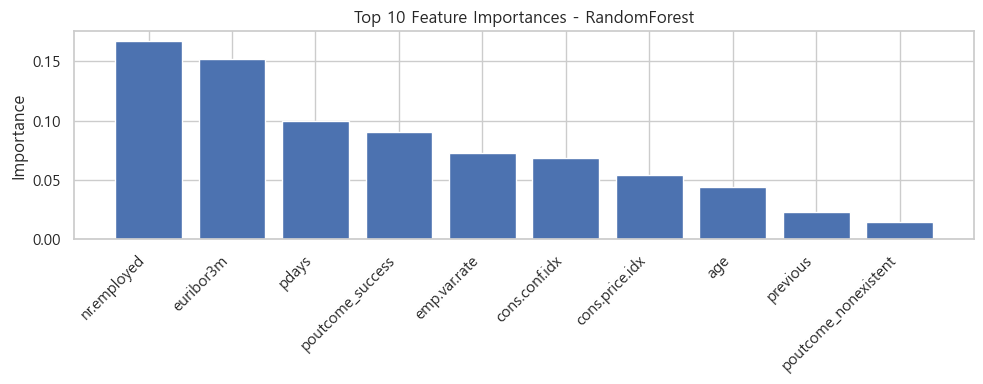

In [26]:
# 5-3. 중요 변수 TOP10 시각화
plt.figure(figsize=(10,4))
plt.bar(top10["feature"], top10["importance"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Importance")
plt.title(f"Top 10 Feature Importances - {best_model_name}")
plt.tight_layout()
plt.show()

### 마케팅 전략 3가지 (RandomForest 중요 변수 기반)

- 전략 1) **이전 캠페인 반응 기반 “재타깃”을 최우선으로 한다.**  
  - 근거 변수: `poutcome_success`, `pdays`, `previous`, `poutcome_nonexistent`  
  - 실행 방안:
    - 과거 캠페인에서 **성공(poutcome=success)** 했던 고객은 “재가입/추가 가입” 가능성이 높을 수 있으므로 우선 콜 리스트에 올린다.
    - `pdays`(이전 캠페인 이후 경과일)와 `previous`(이전 연락 횟수)를 함께 보고, **최근에 접촉했지만 실패한 고객**은 빈번한 재접촉을 줄이고, **충분히 시간이 지난 고객**을 중심으로 재시도한다.
    - `poutcome_nonexistent`(과거 캠페인 접촉 이력 없음) 고객은 별도 세그먼트로 분리해, 첫 접촉용 메시지/오퍼를 다르게 설계한다.

- 전략 2) **거시 환경(금리/고용 지표)에 맞춰 캠페인 “타이밍/예산”을 조정한다.**  
  - 근거 변수: `nr.employed`, `euribor3m`, `emp.var.rate`, `cons.conf.idx`, `cons.price.idx`  
  - 실행 방안:
    - 위 변수들은 고객 개인을 바꾸기보다는 “그 시점의 환경”을 반영하므로, 모델 예측 확률이 전반적으로 높아지는 구간(기간)에 **콜 인력/예산을 집중**한다.
    - 반대로 전반적인 전환이 낮아지는 환경에서는 무리한 확장보다 **고확률 고객(전략 1의 우선군) 중심의 보수적 운영**으로 효율을 지킨다.

- 전략 3) **연령 기반 세그먼트로 메시지/상품 설명을 차별화한다.**  
  - 근거 변수: `age`  
  - 실행 방안:
    - 연령대별로 자산 상황/리스크 선호가 다를 수 있으므로, 예측 확률이 높은 연령 세그먼트를 중심으로
      - 안정성 강조(원금/이자 구조 설명),
      - 가입 장벽 최소화(절차 안내),
      - 상담 스크립트(예: 장기/단기 니즈) 등을 다르게 구성한다.

## 6단계) 최종 정리 및 제출용 결과 정리

이번 단계 목표:
- 모델 비교 결과 요약
- 최종 모델 성능(ROC-AUC, F1) 재확인
- 중요 변수 TOP10 요약
- 마케팅 전략 3가지 정리
- 한계와 다음 단계(간단히) 작성

In [27]:
# 6-1. 최종 모델 성능 한 번에 요약 출력
from sklearn.metrics import roc_auc_score, f1_score

# best_model_name, final_model, results_df, top10 이 앞 단계에서 만들어져 있어야 함
display(results_df)

# 최종 모델의 test 성능 재확인
if hasattr(final_model, "predict_proba"):
    y_proba = final_model.predict_proba(X_test)[:, 1]
else:
    y_proba = final_model.decision_function(X_test)

y_pred = (y_proba >= 0.5).astype(int)

final_auc = roc_auc_score(y_test, y_proba)
final_f1 = f1_score(y_test, y_pred)

print(f"[FINAL MODEL] {best_model_name}")
print(f"ROC-AUC: {final_auc:.4f}")
print(f"F1     : {final_f1:.4f}")

,model,roc_auc,f1
1,RandomForest,0.810949,0.340181
2,GradientBoosting,0.809147,0.350598
0,DecisionTree,0.800229,0.368827


[FINAL MODEL] RandomForest
ROC-AUC: 0.8109
F1     : 0.3402


In [28]:
# 6-2. 중요 변수 TOP10
print("Top 10 Feature Importances")
display(top10)


Top 10 Feature Importances


,feature,importance
8,nr.employed,0.167051
7,euribor3m,0.152197
2,pdays,0.099643
61,poutcome_success,0.090855
4,emp.var.rate,0.072444
6,cons.conf.idx,0.068317
5,cons.price.idx,0.054346
0,age,0.044234
3,previous,0.022690
60,poutcome_nonexistent,0.015023


### 결론 요약(초안)

- **문제 정의:** 은행 마케팅 캠페인 데이터를 바탕으로 고객의 정기예금 가입 여부(y)를 예측하는 분류 모델을 구축했다.
- **모델 비교:** DecisionTree, RandomForest, Boosting 모델을 동일한 전처리/평가지표(ROC-AUC, F1) 기준으로 비교했다.
- **최종 모델:** ROC-AUC(및 F1) 기준으로 **최종 모델을 1개 선택**했고, 테스트 데이터에서 성능을 확인했다.
- **핵심 인사이트:** 중요 변수 TOP10을 통해 가입 예측에 영향을 주는 주요 요인을 확인했다.
- **마케팅 전략:** (5단계에서 작성한) 전략 3가지를 제안한다.

### 한계(간단히)
- 본 분석은 분류 성능을 중심으로 비교했으며, 실제 캠페인 비용/수익 구조를 반영한 최적화(예: 예산 제약, 콜 가능 인원, 기대 수익)는 별도 설계가 필요하다.
- 중요도(feature importance)는 방향성(+) / (-)이나 인과관계를 직접 의미하지 않으므로, 추가 분석이 필요하다.